In [6]:
import os
import re
import time
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import net.model


torch.manual_seed(1)

In [94]:
class Encoder(nn.Module):
    def __init__(self, input_dim=153, logit_size=100, kernel_wins=[3, 4, 5]):
        super(Encoder, self).__init__()

        self.convs = nn.ModuleList([nn.Conv1d(input_dim, logit_size, size) for size in kernel_wins])

        self.dropout = nn.Dropout(0.6)

        self.fc = nn.Linear(len(kernel_wins)*logit_size, logit_size)

    def forward(self, x):
        con_x = [conv(x) for conv in self.convs]

        pool_x = [F.max_pool1d(x.squeeze(-1), x.size()[2]) for x in con_x]
        
        fc_x = torch.cat(pool_x, dim=1)

        fc_x = self.dropout(fc_x)

        fc_x = fc_x.squeeze(-1)

        logit = self.fc(fc_x)

        return logit


inputs = torch.randn(1, 153, 6)

encoder = Encoder(153, 100, [3, 4, 5])

y = encoder(inputs)



In [95]:
class myGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, target_size):
        super(myGRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.r_layer_i = nn.Linear(self.input_size, self.hidden_size)
        self.r_layer_h = nn.Linear(self.hidden_size, self.hidden_size)
        self.z_layer_i = nn.Linear(self.input_size, self.hidden_size)
        self.z_layer_h = nn.Linear(self.hidden_size, self.hidden_size)
        self.n_layer_i = nn.Linear(self.input_size, self.hidden_size)
        self.n_layer_h = nn.Linear(self.hidden_size, self.hidden_size)

        self.fc = nn.Linear(hidden_size, target_size)

    def forward(self, input, hidden):
        #print(input.shape, hidden.shape)
        r = torch.sigmoid(self.r_layer_i(input) + self.r_layer_h(hidden))
        z = torch.sigmoid(self.z_layer_i(input) + self.r_layer_h(hidden))
        n = torch.tanh(self.n_layer_i(input) + torch.mul(r, self.n_layer_h(hidden)))
        next_hidden = torch.mul((1-z), n) + torch.mul(z, hidden)

        # extra full connect
        y = self.fc(next_hidden)

        return y, next_hidden

    def init_hidden(self, hidden_size):
        return torch.zeros(1, hidden_size)

    

In [111]:
class myGRU(nn.Module):
    def __init__(self, input_size, hidden_size, target_size, logit_size):
        super(myGRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.target_size = target_size
        self.logit_size = logit_size
        self.myGRUCell = myGRUCell(input_size, hidden_size + logit_size, target_size)

    def get_stacking_hidden(self, hidden, logit):
        return torch.cat((hidden, logit), dim=1)

    def forward(self, inputs, logit):

        #print(inputs.shape, logit.shape)

        inputs = inputs.unsqueeze(dim=1)

        hidden = self.myGRUCell.init_hidden(self.hidden_size)

        if not logit == None:
            hidden = self.get_stacking_hidden(hidden, logit) # sharp for test navie gru

        y, hidden = self.myGRUCell(inputs[0], hidden)

        for i in range(1, inputs.shape[0]):
            y_next, hidden = self.myGRUCell(inputs[i], hidden)

            y = torch.cat([y,y_next], dim=0)

        return y

rnn = myGRU(2, 40, 1, 20)# element_dim, doubled hidden_dim, target_dim
logit = torch.randn(1, 20)
inputs = torch.randn(5, 1, 2)
output = rnn(inputs, logit)

print(output.shape)


torch.Size([5, 1, 1])


In [115]:
class Trans_GRU(nn.Module):
    def __init__(self, element_dim=153, matrix_dim=153, hidden_dim=20, target_size=1, logit_size=20):
        super().__init__()
        self.element_dim = element_dim

        self.matrix = matrix_dim

        self.hidden_dim = hidden_dim

        self.target_size = target_size

        self.logit_size = logit_size

        if not logit_size == 0:
            self.encoder = Encoder(input_dim=matrix_dim, logit_size=logit_size, kernel_wins=[3, 4, 5])

        self.rnn = myGRU(element_dim, hidden_dim, target_size,logit_size)

    def forward(self, sentence, matrix):
        if self.logit_size == 0:
            logit = None
        else:
            logit = self.encoder(matrix)

        rnn_out = self.rnn(sentence.view(len(sentence), 1, -1), logit)

        return rnn_out


matrix = torch.randn(1, 153, 6)

inputs = torch.randn(20, 1, 1)

fesnet = Trans_GRU(element_dim=1, matrix_dim=153, hidden_dim=20, target_size=1, logit_size=2)

rnn = fesnet(inputs, matrix)

print(rnn.shape)


torch.Size([20, 1, 1])


In [45]:
class LSTM(nn.Module):
    def __init__(self, element_dim, hidden_dim, output_size, num_layers=2):
        super().__init__()
        self.element_dim = element_dim

        self.hidden_dim = hidden_dim

        self.num_layers = num_layers

        self.encoder = Encoder(matrix_dim=element_dim, extra_hidden_dim=hidden_dim, kernel_wins=[3, 4, 5])

        #self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers)

        self.rnn = myGRU(element_dim, hidden_dim, num_layers)

        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, sentence, matrix):
        feature = self.encoder(matrix)

        lstm_out, _ = self.rnn(sentence.view(len(sentence), 1, -1))
        
        out = self.fc(lstm_out.view(len(sentence), -1))
        
        return out


from IPython.display import Image
Image(url= "gru.jpg", width=400, height=400)
    

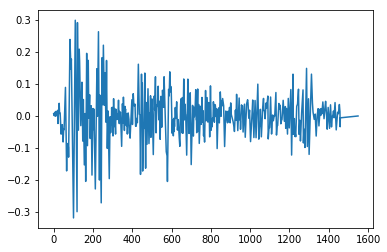

torch.Size([1550, 1])


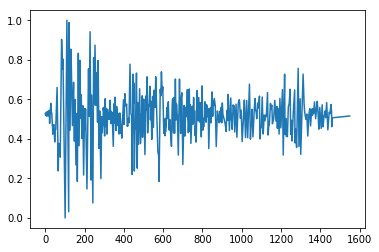

In [46]:

import utils.load_acc

earthquake = utils.load_acc.get_earthquake_data()[:]

plt.plot(earthquake)

plt.show()

#data = torch.tensor(utils.load_acc.task()).to(torch.float32)
#data = (data.T)[5:7].reshape(len(data), -1)
#data = torch.rand(101, element_dim)
data = torch.tensor(earthquake).reshape(len(earthquake), 1).to(torch.float32)
#print(data.shape)

from sklearn.preprocessing import MinMaxScaler

s = MinMaxScaler()

data = torch.tensor(s.fit_transform(data)).to(torch.float32)

print(data.shape)

plt.plot(data)
plt.show()

In [59]:
#extra process
from sklearn.preprocessing import StandardScaler

import preprocess

stiffness_o, mass_o = preprocess.task()

print("origin:")
#print(stiffness_o[0])
#print(mass_o[0])

ss_s, ss_m = MinMaxScaler(), MinMaxScaler()
ss_s.fit(stiffness_o);ss_m.fit(mass_o)

stiffness, mass = ss_s.transform(stiffness_o), ss_m.transform(mass_o)

print("after: ")
#print(stiffness[0], mass[0])

print(stiffness.shape, mass.shape)

matrix = torch.tensor(np.append(stiffness, mass, axis=0))

matrix = matrix.transpose(1,0)

matrix = torch.unsqueeze(matrix, dim=0).to(torch.float32)

print(matrix.shape)


origin:
after: 
(3, 153) (3, 153)
torch.Size([1, 153, 6])


epoch:  0 current_loss:  48.93414826953813
epoch:  1 current_loss:  0.7515117192670004
epoch:  2 current_loss:  0.48382297679927433
epoch:  3 current_loss:  0.33364879729469976
epoch:  4 current_loss:  0.3713864831115643
epoch:  5 current_loss:  0.28971181694214465
epoch:  6 current_loss:  0.252049120987067
epoch:  7 current_loss:  0.22552937511136406
epoch:  8 current_loss:  0.20398138876407756
epoch:  9 current_loss:  0.21313922737317625


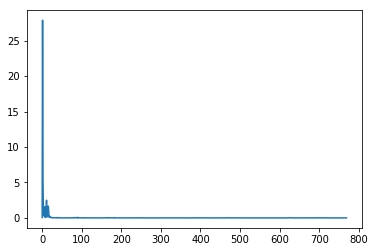

In [116]:
"""
Super para : 
    lr = 0.05;
    hidden_dim = 10
    epoch = 20
    max_length = 20
    clip_threh = 5
"""
def pretty_time(time, degree=1):
    return str(int(time // 60)) + "m" + str(round(time % 60, degree)) if time > 60 else round(time, degree)

element_dim = data.shape[-1]

#net = LSTM(element_dim=element_dim, hidden_dim=10, output_size=element_dim)
net = Trans_GRU(element_dim=element_dim, matrix_dim=153, hidden_dim=200, target_size=1, logit_size=0)
#net = myGRU(input_size=element_dim, hidden_size=10, target_size=1)

#from net.model import FesNet
#net = FesNet(element_dim=element_dim, nhead=1, num_layers=6)

criterion =  nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=0.05)

start_time = time.time()

loss_list = []

max_length = 20

length = len(data)

for epoch in range(10):
    i = 0
    current_loss = 0
    while i + max_length < len(data):
        
        inputs, targets = data[i:i+max_length], data[i+1:i+1+max_length]

        #inputs, targets = torch.unsqueeze(inputs, dim=1), torch.unsqueeze(targets, dim=1)
        
        inputs = torch.unsqueeze(inputs, dim=1)

        #print(inputs.shape, matrix.shape, targets.shape)

        #predicts = net(inputs, targets).squeeze(dim=1)
        
        predicts = net(inputs, matrix).squeeze(dim=1)

        net.zero_grad()
        
        loss = criterion(predicts, targets)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(net.parameters(), 0.5)

        optimizer.step()

        current_loss += loss.item()

        i += max_length

        loss_list.append(loss.item())
    
    print("epoch: ", epoch, "current_loss: ", current_loss)

plt.plot(loss_list)

plt.show()


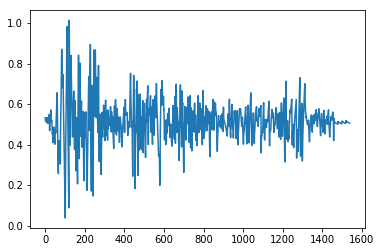

In [117]:
pre = torch.tensor([])
i = 0
while i + max_length < len(data):
    inputs, targets = data[i:i+max_length], data[i+1:i+1+max_length]

    #inputs, targets = torch.unsqueeze(inputs, dim=1), torch.unsqueeze(targets, dim=1)

    #predicts = net(inputs, targets).reshape(max_length, -1)

    inputs = torch.unsqueeze(inputs, dim=1)

    #predicts = net(inputs).reshape(max_length, -1)

    predicts = net(inputs, matrix).squeeze(dim=1)

    pre = torch.cat((pre, predicts))

    i += max_length

pre = pre.detach().numpy()

plt.plot(pre)

plt.show()

In [56]:
plt.plot((pre.T)[7])
plt.show()

IndexError: index 7 is out of bounds for axis 0 with size 1

In [41]:
plt.plot((data.T)[7])
plt.show()

IndexError: index 7 is out of bounds for dimension 0 with size 1

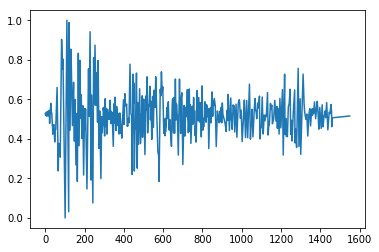

In [57]:
plt.plot(data)
plt.show()